# Environment Setup

In [2]:
from google.colab import userdata
import os

# 1. Get the token from the Secrets manager
token = userdata.get('GITHUB_TOKEN')

# 2. Define your username and repo name
username = "Osiris-H"
repo_name = "ESE-438-Project"

# 3. Clone using the token
# Format: https://<token>@github.com/<username>/<repo>.git
clone_url = f"https://{token}@github.com/{username}/{repo_name}.git"

!git clone {clone_url}

fatal: destination path 'ESE-438-Project' already exists and is not an empty directory.


In [3]:
%cd /content/ESE-438-Project
!git checkout -b FourCastNet origin/FourCastNet

/content/ESE-438-Project
Branch 'FourCastNet' set up to track remote branch 'FourCastNet' from 'origin'.
Switched to a new branch 'FourCastNet'


In [4]:
!pip -q install ruamel.yaml einops timm
!pip -q install xarray zarr gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 122.7 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [6]:
%cd /content/ESE-438-Project/FourCastNet

/content/ESE-438-Project/FourCastNet


In [7]:
import os, sys, time
import json
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
from collections import OrderedDict

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [9]:
data_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/2022.h5"
global_means_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/global_means.npy"
global_stds_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/global_stds.npy"
time_means_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/time_means.npy"
config_file = "/content/ESE-438-Project/FourCastNet/config/AFNO.yaml"

# Metrics

## Weighting

In [ ]:
def lat_centers(num_lat: int, device=None) -> torch.Tensor:
    j = torch.arange(num_lat, device=device, dtype=torch.float32)
    dphi = 180.0 / float(num_lat - 1)
    phi_center = 90.0 - j * dphi
    return phi_center  # degrees


def latitude_area_weights(num_lat: int, device=None) -> torch.Tensor:
    """
    Compute w(i) ∝ sin(theta_u) - sin(theta_l), normalized to sum to 1.
    """
    phi_center = lat_centers(num_lat, device=device)
    dphi = 180.0 / float(num_lat - 1)

    phi_upper_deg = torch.clamp(phi_center + 0.5 * dphi, max=90.0)
    phi_lower_deg = torch.clamp(phi_center - 0.5 * dphi, min=-90.0)

    phi_upper = torch.deg2rad(phi_upper_deg)
    phi_lower = torch.deg2rad(phi_lower_deg)

    w_raw = torch.sin(phi_upper) - torch.sin(phi_lower)  # [H]
    w = w_raw / w_raw.sum()
    return w  # [H]

## RMSE

In [ ]:
def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Compute latitude-area-weighted RMSE per channel.

    Args:
        pred, target: tensors of shape [B, C, H, W]
                      (batch, channels, latitude, longitude)

    Returns:
        rmse: tensor of shape [B, C]
              (one RMSE per channel for each batch sample)
    """
    assert pred.shape == target.shape, "pred and target must have same shape"
    assert pred.dim() == 4, "expected shape [B, C, H, W]"

    B, C, H, W = pred.shape
    device = pred.device

    err2 = (pred - target) ** 2  # [B, C, H, W]

    # latitude weights w_i (sum to 1)
    w_lat = latitude_area_weights(H, device=device)     # [H]
    w_lat = w_lat.view(1, 1, H, 1)                      # [1,1,H,1]

    # mean over longitude, then weighted sum over latitude
    # mean over W: [B, C, H]
    err2_mean_lon = err2.mean(dim=-1)                   # [B, C, H]

    # weighted sum over H (since sum_i w_i = 1)
    mse = (w_lat.squeeze(-1) * err2_mean_lon).sum(dim=-1)  # [B, C]

    rmse = torch.sqrt(mse)
    return rmse

## ACC

In [ ]:
def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Latitude-area-weighted ACC (anomaly correlation / pattern correlation)
    per channel.

    pred, target: [B, C, H, W]  (batch, channels, lat, lon)

    Returns:
        acc: [B, C]
    """
    assert pred.shape == target.shape
    assert pred.dim() == 4

    B, C, H, W = pred.shape
    device = pred.device

    # latitude area weights w(j) based on sin(theta_u) - sin(theta_l)
    w_lat = latitude_area_weights(H, device=device)   # [H]
    w = w_lat.view(1, 1, H, 1)                        # [1, 1, H, 1] for broadcasting

    # numerator: weighted dot product
    num = torch.sum(w * pred * target, dim=(-1, -2))  # [B, C]

    # denominator: product of weighted norms
    denom = torch.sqrt(
        torch.sum(w * pred * pred, dim=(-1, -2)) *
        torch.sum(w * target * target, dim=(-1, -2)) + 1e-12
    )  # [B, C]

    acc = num / denom
    return acc

## MAE

In [ ]:
def weighted_mae_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Latitude-area-weighted MAE per channel.

    Args:
        pred, target: [B, C, H, W]  (batch, channels, lat, lon)

    Returns:
        mae: [B, C]  (MAE for each batch sample and channel)
    """
    assert pred.shape == target.shape, "pred and target must have same shape"
    assert pred.dim() == 4, "expected shape [B, C, H, W]"

    B, C, H, W = pred.shape
    device = pred.device

    err_abs = torch.abs(pred - target)          # [B, C, H, W]

    # latitude weights w_i (sum to 1)
    w_lat = latitude_area_weights(H, device=device)  # [H]
    w_lat = w_lat.view(1, 1, H)                      # [1, 1, H]

    # mean over longitude (uniform grid)
    err_abs_mean_lon = err_abs.mean(dim=-1)         # [B, C, H]

    # weighted sum over latitude
    mae = (w_lat * err_abs_mean_lon).sum(dim=-1)    # [B, C]

    return mae

## RMSB

In [ ]:
def weighted_rmsb_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Compute globally averaged root mean squared bias (RMSB) per channel.

    Args:
        pred, target: tensors of shape [T, C, H, W]
                      T = time, C = channels/variables,
                      H = latitude, W = longitude.

    Returns:
        rmsb: tensor of shape [C]  (RMSB for each channel)
    """
    assert pred.shape == target.shape, "pred and target must have same shape"
    assert pred.dim() == 4, "expected shape [T, C, H, W]"

    T, C, H, W = pred.shape
    device = pred.device

    # 1) Bias_{i,j} per channel: average over time
    #    Bias[c, i, j] = (1/T) Σ_t (pred - target)
    bias = torch.mean(pred - target, dim=0)      # [C, H, W]

    # 2) Latitude area weights w(i)
    w_lat = latitude_area_weights(H, device=device)  # [H]
    w = w_lat.view(1, H, 1)                          # [1, H, 1] for broadcasting

    # 3) Weighted mean of squared bias over lat & lon
    #    Here we do: Σ_i Σ_j w(i) * Bias^2 / W
    #    (w(i) is normalized to sum to 1, so this is
    #     consistent with area weighting + mean over lon.)
    msb = torch.mean(w * bias**2, dim=(-1, -2))  # [C]

    # 4) Root mean squared bias
    rmsb = torch.sqrt(msb)                       # [C]

    return rmsb


In [ ]:
def weighted_rmsb_from_bias(bias_np: np.ndarray) -> float:
    """
    Compute RMSB from a single-channel bias map.

    Args:
        bias_np: numpy array of shape [H, W] (bias over latitude x longitude)

    Returns:
        rmsb (float): scalar RMSB value
    """
    assert bias_np.ndim == 2, "bias must be shape [H, W]"

    # convert to torch
    bias = torch.tensor(bias_np, dtype=torch.float32)
    H, W = bias.shape
    device = bias.device

    # latitude weights w(i), shape [H]
    w_lat = latitude_area_weights(H, device=device)  # [H]
    w = w_lat.view(H, 1)                             # [H, 1] for broadcasting

    # weighted mean of squared bias
    # mean over W (longitude), weighted sum over H (latitude)
    msb = torch.mean(w * (bias ** 2), dim=1).sum()   # scalar

    rmsb = torch.sqrt(msb).item()

    return rmsb

# Evaluation

## Prepare Model

In [10]:
from networks.afnonet import AFNONet, PrecipNet
from utils.YParams import YParams

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [11]:
def load_model(model, params, checkpoint_file, map_location="cpu"):
    """
    Helper function to load model weights from a checkpoint.

    - Works with PyTorch >= 2.6 by explicitly setting weights_only=False
      (avoids the UnpicklingError with ruamel.yaml ScalarFloat).
    - Handles both DDP ("module.") and non-DDP checkpoints.
    """
    # --- load checkpoint safely across PyTorch versions ---
    try:
        # PyTorch 2.6+ (has weights_only argument)
        checkpoint = torch.load(
            checkpoint_file,
            map_location=map_location,
            weights_only=False   # <--- IMPORTANT
        )
    except TypeError:
        # Older PyTorch that doesn't know weights_only
        checkpoint = torch.load(checkpoint_file, map_location=map_location)

    # --- get the state dict ---
    # some checkpoints store directly as a dict, some under 'model_state'
    state_dict = checkpoint.get('model_state', checkpoint)

    # --- strip "module." prefix if present (DDP) and skip 'ged' ---
    new_state_dict = OrderedDict()
    for key, val in state_dict.items():
        name = key
        if name.startswith("module."):
            name = name[len("module."):]
        if name == "ged":
            continue
        new_state_dict[name] = val

    # --- load into model ---
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()  # set to inference mode
    return model

### Default

In [12]:
config_name = "afno_backbone"
params = YParams(config_file, config_name)
print("Model architecture used = {}".format(params["nettype"]))

in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels]
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]

Model architecture used = afno


In [13]:
model_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/backbone.ckpt"
model = AFNONet(params).to(device)
model = load_model(model, params, model_path)
model = model.to(device)

### Precip

In [14]:
config_name = "precip"
params = YParams(config_file, config_name)

in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels]
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]

In [15]:
model_path = "/content/drive/MyDrive/UPenn/ESE 5380/FourCastNet/precip.ckpt"
backbone = AFNONet(params).to(device)
precip_model = PrecipNet(params, backbone=backbone).to(device)
precip_model = load_model(precip_model, params, model_path).to(device)

## Prepare Data

In [16]:
img_shape_x = 720
img_shape_y = 1440

means = params.means
stds = params.stds
print(means.shape, stds.shape)

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

(1, 1, 1) (1, 1, 1)
Shape of time means = torch.Size([1, 1, 720, 1440])
Shape of std = torch.Size([1])


## Inference

In [ ]:
def inference(data_slice, model, prediction_length):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    mae = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    # bias = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    residuals = []

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    # targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    # predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                # targets[0,0] = first[0,idx]
                # predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            # if i < prediction_length - 1:
            #     predictions[i+1,0] = future_pred[0,idx]
            #     targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            mae[i] = weighted_mae_channels(pred, tar) * std
            # rmsb[i] = weighted_rmsb_channels(pred, tar) * std
            residuals.append((pred - tar)[0] * std.view(-1, 1, 1))

            pred = future_pred
            tar = future

    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    mae_cpu = mae.cpu().numpy()
    residuals_cpu = torch.stack(residuals, dim=0).cpu().numpy()

    return acc_cpu, rmse_cpu, mae_cpu, residuals_cpu

In [ ]:
src_vars = [
    'u10','v10','t2m','sp','msl','t850',
    'u1000','v1000','z1000','u850','v850','z850',
    'u500','v500','z500','t500','z50','r500','r850','tcwv'
]

tgt_vars = [
    'u10','v10','t2m','msl'
]

# tgt_vars = [
#     '2m_temperature',
#     '10m_u_component_of_wind',
#     '10m_v_component_of_wind',
#     'mean_sea_level_pressure',
#     'total_precipitation_24hr'
# ]

In [ ]:
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 9 # number of steps (x 6 hours)
lead_hours = list(range(6, 49, 6))
# metrics = {
#     v: {lh: {"acc": [], "rmse": [], "mae": [], "res": []} for lh in lead_hours} for v in tgt_vars
# }

metrics = {
    v: {
        lh: {
            "acc": [],
            "rmse": [],
            "mae": [],
            "res_sum": np.zeros((img_shape_x, img_shape_y), dtype=np.float64),
            "count": 0
        }
        for lh in lead_hours
    }
    for v in tgt_vars
}

for i in tqdm(range(0, 40, 4)):
    # print(ic)
    data = h5py.File(data_path, 'r')['fields'][ic:(ic+prediction_length*dt):dt, in_channels,0:img_shape_x]
    if data.shape[0] != prediction_length:
        continue
    # print(data.shape[0])
    data = (data - means) / stds
    data = torch.as_tensor(data).to(device, dtype=torch.float)
    acc_cpu, rmse_cpu, mae_cpu, res_cpu = inference(data, model, prediction_length)

    for tgt_var in tgt_vars:
        var_idx = src_vars.index(tgt_var)
        for step, lh in enumerate(lead_hours):
            metrics[tgt_var][lh]['acc'].append(float(acc_cpu[step + 1][var_idx]))
            metrics[tgt_var][lh]['rmse'].append(float(rmse_cpu[step + 1][var_idx]))
            metrics[tgt_var][lh]['mae'].append(float(mae_cpu[step + 1][var_idx]))
            res_field = res_cpu[step + 1][var_idx]
            metrics[tgt_var][lh]['res_sum'] += res_field
            metrics[tgt_var][lh]['count'] += 1

    ic += 4

100%|██████████| 10/10 [01:36<00:00,  9.70s/it]


In [ ]:
metrics_agg = {}
for var_name in tgt_vars:
    metrics_agg[var_name] = {}
    for lh in lead_hours:
        acc_list = metrics[var_name][lh]["acc"]
        rmse_list = metrics[var_name][lh]["rmse"]
        mae_list = metrics[var_name][lh]["mae"]
        T = metrics[var_name][lh]["count"]
        bias = metrics[var_name][lh]["res_sum"] / T
        metrics_agg[var_name][lh] = {
            "acc": float(np.mean(acc_list)),
            "rmse": float(np.mean(rmse_list)),
            "mae": float(np.mean(mae_list)),
            "rmsb": float(weighted_rmsb_from_bias(bias))
        }

In [ ]:
with open("FourCastNet_results.json", "w") as f:
    json.dump(metrics_agg, f, indent=2)

## Precipitation

In [40]:
def unlog_tp_torch(x, eps=1e-5):
#    return torch.exp(x + torch.log(eps)) - eps
    return eps*(torch.exp(x)-1)

def unlog_tp_np(x, eps=1e-5):
    return eps * (np.exp(x) - 1)

In [31]:
dt = 1 # time step (x 6 hours)
ic = 0
pred_steps = 2
data = h5py.File(data_path, 'r')['fields'][ic:(ic+pred_steps*dt):dt, :20, 0:720]
# print(data.shape)
data = (data - means) / stds
data = torch.as_tensor(data).to(device, dtype=torch.float)

In [51]:
temp = h5py.File(data_path, 'r')['fields'][1, -1, :720, :]
print(temp)

[[   271.45996    271.45996    271.45996 ...    271.45996    271.45996
     271.45996]
 [   271.45996    271.45996    271.45996 ...    271.45996    271.45996
     271.45996]
 [   271.45996    271.45996    271.45996 ...    271.45996    271.45996
     271.45996]
 ...
 [-32767.      -32767.      -32767.      ... -32767.      -32767.
  -32767.     ]
 [-32767.      -32767.      -32767.      ... -32767.      -32767.
  -32767.     ]
 [-32767.      -32767.      -32767.      ... -32767.      -32767.
  -32767.     ]]


In [42]:
targets = torch.zeros((pred_steps-1, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
predictions = torch.zeros((pred_steps-1, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
with torch.no_grad():
    prev = data[0:1]
    for i in range(data.shape[0]):
        if i >= pred_steps-1:
            break
        future_pred = model(prev)
        future_pred_tp = precip_model(future_pred)
        predictions[i] = unlog_tp_torch(future_pred_tp)
        # predictions[i] = future_pred_tp
        targets[i] = data[i+1, -1]
        prev = future_pred

predictions_cpu = predictions.cpu().numpy()
targets_cpu = targets.cpu().numpy()

## Quantile

In [ ]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            pred = future_pred
            tar = future

    # copy to cpu for plotting/vis
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()

    return predictions_cpu, targets_cpu

In [ ]:
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 20 # number of steps (x 6 hours)

# which field to track for visualization
field = 'msl'
idx_vis = src_vars.index(field) # also prints out metrics for this field
data = h5py.File(data_path, 'r')['fields'][ic:(ic+prediction_length*dt):dt,in_channels,0:img_shape_x]

In [ ]:
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)

In [23]:
def quantiles(x, qtile):
    ''' helper to compute quantiles based on qtile of the field '''
    n, c, h, w = x.shape
    return np.quantile(x.reshape((n,c,h*w)), q=qtile, axis=-1).squeeze()

In [24]:
qs = 100
qlim = 4
qcut = 1
qtile = 1. - np.logspace(-qlim, -qcut, num=qs) # log-spaced bins for quantiles

# compute quantiles for the fields saved (channel idx_vis is saved out now)
era5_q = quantiles(targets_cpu, qtile)
mean_era5 = era5_q.mean(axis=1) # stats over different time points
std_era5 = era5_q.std(axis=1)

pred_q = quantiles(predictions_cpu, qtile) # for predictions
mean_pred = pred_q.mean(axis=1)
std_pred = pred_q.std(axis=1)

print(era5_q.shape, pred_q.shape)

(100, 8) (100, 8)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [25]:
field = 'tp'

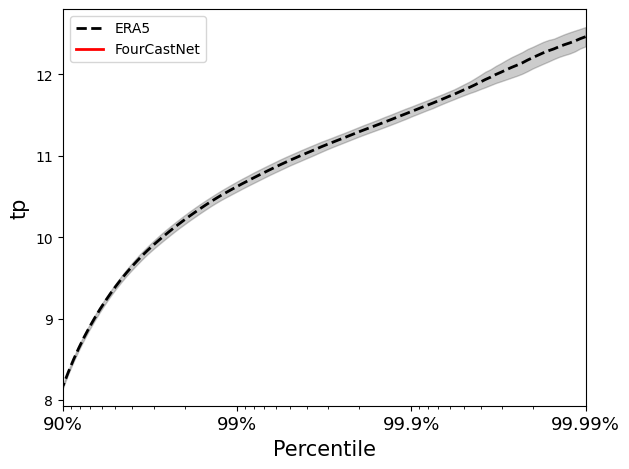

In [26]:
# plot the extremes
plt.figure()
fs=15
ax = plt.gca() #axs[0]
qtiles = np.logspace(-qlim, -qcut, num=qs)
ax.plot(qtiles, mean_era5, 'k--', label='ERA5', lw=2)
ax.fill_between(qtiles, mean_era5+std_era5, mean_era5-std_era5, alpha=0.2, color='k')
ax.plot(qtiles, mean_pred, 'r-', label='FourCastNet', lw=2)
ax.fill_between(qtiles, mean_pred+std_pred, mean_pred-std_pred, alpha=0.2, color='r')
ax.set_xlim((qtiles[-1], qtiles[0]))
ax.set_xscale('log')
ax.set_xticks(ticks=10.**np.arange(-1,-qlim - 1, -1))
ax.set_xticklabels(labels=['%g%%'%(100.*(1. - 10.**q)) for q in np.arange(-1,-qlim - 1, -1)], fontsize=fs-2)
ax.set_xlabel('Percentile', fontsize=fs)
ax.set_ylabel(f'{field}', fontsize=fs)
ax.legend()
plt.tight_layout()